In [5]:
# Cell 1: Import required libraries
#import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import spacy
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from typing import Dict, Any
import logging
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import spacy
import en_core_web_sm

nlp = en_core_web_sm.load()
print("SpaCy model loaded successfully!")


# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)



SpaCy model loaded successfully!


In [6]:
# Cell 2: Define the RAGEvaluator class
class RAGEvaluator:
    def __init__(self, spacy_model: str = "en_core_web_sm", sentence_transformer: str = 'all-MiniLM-L6-v2'):
        """
        Initialize the RAG evaluator with required models.
        """
        logger.info("Initializing RAG Evaluator...")
        self.nlp = spacy.load(spacy_model)
        self.model = SentenceTransformer(sentence_transformer)

    def compute_cosine_similarity(self, vec1: np.ndarray, vec2: np.ndarray) -> float:
        """Compute cosine similarity between two vectors."""
        return float(cosine_similarity([vec1], [vec2])[0][0])

    def evaluate_faithfulness(self, generated_answer: str, context: str) -> float:
        """Evaluate how faithful the generated answer is to the context."""
        context_embedding = self.model.encode([context])[0]
        answer_embedding = self.model.encode([generated_answer])[0]
        return self.compute_cosine_similarity(context_embedding, answer_embedding)

    def evaluate_answer_relevancy(self, answer: str, query: str) -> float:
        """Evaluate how relevant the answer is to the query."""
        query_embedding = self.model.encode([query])[0]
        answer_embedding = self.model.encode([answer])[0]
        return self.compute_cosine_similarity(query_embedding, answer_embedding)

    def evaluate_context_metrics(self, query: str, context: str) -> Dict[str, float]:
        """Evaluate context recall and precision."""
        query_doc = self.nlp(query)
        context_doc = self.nlp(context)

        query_entities = {ent.text.lower() for ent in query_doc.ents}
        context_entities = {ent.text.lower() for ent in context_doc.ents}

        if not query_entities:
            return {"recall": 0.0, "precision": 0.0}

        recall = len(query_entities.intersection(context_entities)) / len(query_entities)
        precision = len(query_entities.intersection(context_entities)) / len(context_entities) if context_entities else 0.0

        return {"recall": recall, "precision": precision}

    def evaluate_entity_recall(self, retrieved_context: str, ground_truth: str) -> float:
        """Evaluate entity recall against ground truth."""
        retrieved_doc = self.nlp(retrieved_context)
        truth_doc = self.nlp(ground_truth)

        retrieved_entities = {ent.text.lower() for ent in retrieved_doc.ents}
        truth_entities = {ent.text.lower() for ent in truth_doc.ents}

        return len(retrieved_entities.intersection(truth_entities)) / len(truth_entities) if truth_entities else 0.0

    def evaluate_approach(self, query: str, retrieved_context: str,
                         generated_answer: str, ground_truth: str) -> Dict[str, float]:
        """Evaluate a single RAG approach and return all metrics."""
        try:
            context_metrics = self.evaluate_context_metrics(query, retrieved_context)

            return {
                "faithfulness": self.evaluate_faithfulness(generated_answer, retrieved_context),
                "answer_relevancy": self.evaluate_answer_relevancy(generated_answer, query),
                "context_recall": context_metrics["recall"],
                "context_precision": context_metrics["precision"],
                "entity_recall": self.evaluate_entity_recall(retrieved_context, ground_truth)
            }
        except Exception as e:
            logger.error(f"Error evaluating approach: {str(e)}")
            return {
                "faithfulness": 0.0,
                "answer_relevancy": 0.0,
                "context_recall": 0.0,
                "context_precision": 0.0,
                "entity_recall": 0.0
            }


In [10]:
import pandas as pd
qna_df  = pd.read_csv("../../../Dataset_code_csvs/hotpotQA/hotpotQA_dataset_versions/5884paras_598queries/English/598_QnAs.csv")
simple_df = pd.read_csv("../../results/pipeline results/5884paras_598qna/simple_rag_qna_results_GPU_version.csv")
lqr_df = pd.read_csv("../../results/pipeline results/5884paras_598qna/LQR_processed_results_en.csv")
modlqr_df = pd.read_csv("../../results/pipeline results/5884paras_598qna/modLQR_processed_results_en.csv")

In [11]:
print("QnAs:", len(qna_df ))
print("Simple RAG:", len(simple_df))
print("LQR RAG:", len(lqr_df))
print("modLQR RAG:", len(modlqr_df))

QnAs: 598
Simple RAG: 598
LQR RAG: 598
modLQR RAG: 598


In [14]:
full_df = pd.DataFrame({
    "question": qna_df["question"],
    "context": qna_df["actual_retrieved_sentences"],
    "simple_rag_retrieved_context": simple_df["retrieved_context"],
    "simple_rag_final_answer": simple_df["final_answer"],
    "lqr_rag_retrieved_context": lqr_df["retrieved_context"],
    "lqr_rag_final_answer": lqr_df["final_answer"],
    "modlqr_rag_retrieved_context": modlqr_df["retrieved_context"],
    "modlqr_rag_final_answer": modlqr_df["final_answer"],
    "ground_truth_answer": qna_df["answer"]
})

In [15]:
def evaluate_multiple_rag_approaches(df: pd.DataFrame) -> pd.DataFrame:
    evaluator = RAGEvaluator()
    results = []

    for idx, row in df.iterrows():
        logger.info(f"Evaluating query {idx + 1}/{len(df)}")

        metrics = {}

        for approach in ['simple_rag', 'lqr_rag', 'modlqr_rag']:
            approach_metrics = evaluator.evaluate_approach(
                row["question"],
                row[f"{approach}_retrieved_context"],
                row[f"{approach}_final_answer"],
                row["context"]
            )
            metrics.update({f"{approach}_{k}": v for k, v in approach_metrics.items()})

        results.append({
            "query": row["question"],
            "ground_truth_context": row["context"],
            **metrics
        })

    results_df = pd.DataFrame(results)
    return results_df



In [16]:
def plot_all_metrics(results_df: pd.DataFrame):
    metrics = ['faithfulness', 'answer_relevancy', 'context_recall', 'context_precision', 'entity_recall']
    fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 5 * len(metrics)))
    fig.suptitle('RAG Evaluation Metrics Comparison (3 Approaches)', y=1.02, fontsize=18)

    for ax, metric in zip(axes, metrics):
        data = pd.DataFrame({
            'Simple RAG': results_df[f'simple_rag_{metric}'],
            'LQR RAG': results_df[f'lqr_rag_{metric}'],
            'ModLQR RAG': results_df[f'modlqr_rag_{metric}']
        })
        sns.boxplot(data=data, ax=ax)
        ax.set_title(f'{metric.replace("_", " ").title()}')
        ax.set_ylabel('Score')

    plt.tight_layout()
    plt.show()


2025-05-23 14:38:54,347 - INFO - Initializing RAG Evaluator...
2025-05-23 14:38:54,683 - INFO - Use pytorch device_name: cuda:0
2025-05-23 14:38:54,683 - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2
2025-05-23 14:38:58,215 - INFO - Evaluating query 1/598
Batches: 100%|██████████| 1/1 [00:00<00:00, 92.98it/s]
2025-05-23 14:38:58,654 - INFO - Evaluating query 2/598
Batches: 100%|██████████| 1/1 [00:00<00:00, 317.94it/s]
2025-05-23 14:38:58,902 - INFO - Evaluating query 3/598
Batches: 100%|██████████| 1/1 [00:00<00:00, 144.99it/s]
2025-05-23 14:38:59,155 - INFO - Evaluating query 4/598
Batches: 100%|██████████| 1/1 [00:00<?, ?it/s]
2025-05-23 14:38:59,404 - INFO - Evaluating query 5/598
Batches: 100%|██████████| 1/1 [00:00<00:00, 465.46it/s]
2025-05-23 14:38:59,651 - INFO - Evaluating query 6/598
Batches: 100%|██████████| 1/1 [00:00<00:00, 885.81it/s]
2025-05-23 14:38:59,903 - INFO - Evaluating query 7/598
Batches: 100%|██████████| 1/1 [00:00<?, ?it/s]
2025-05-23 14:39:00,

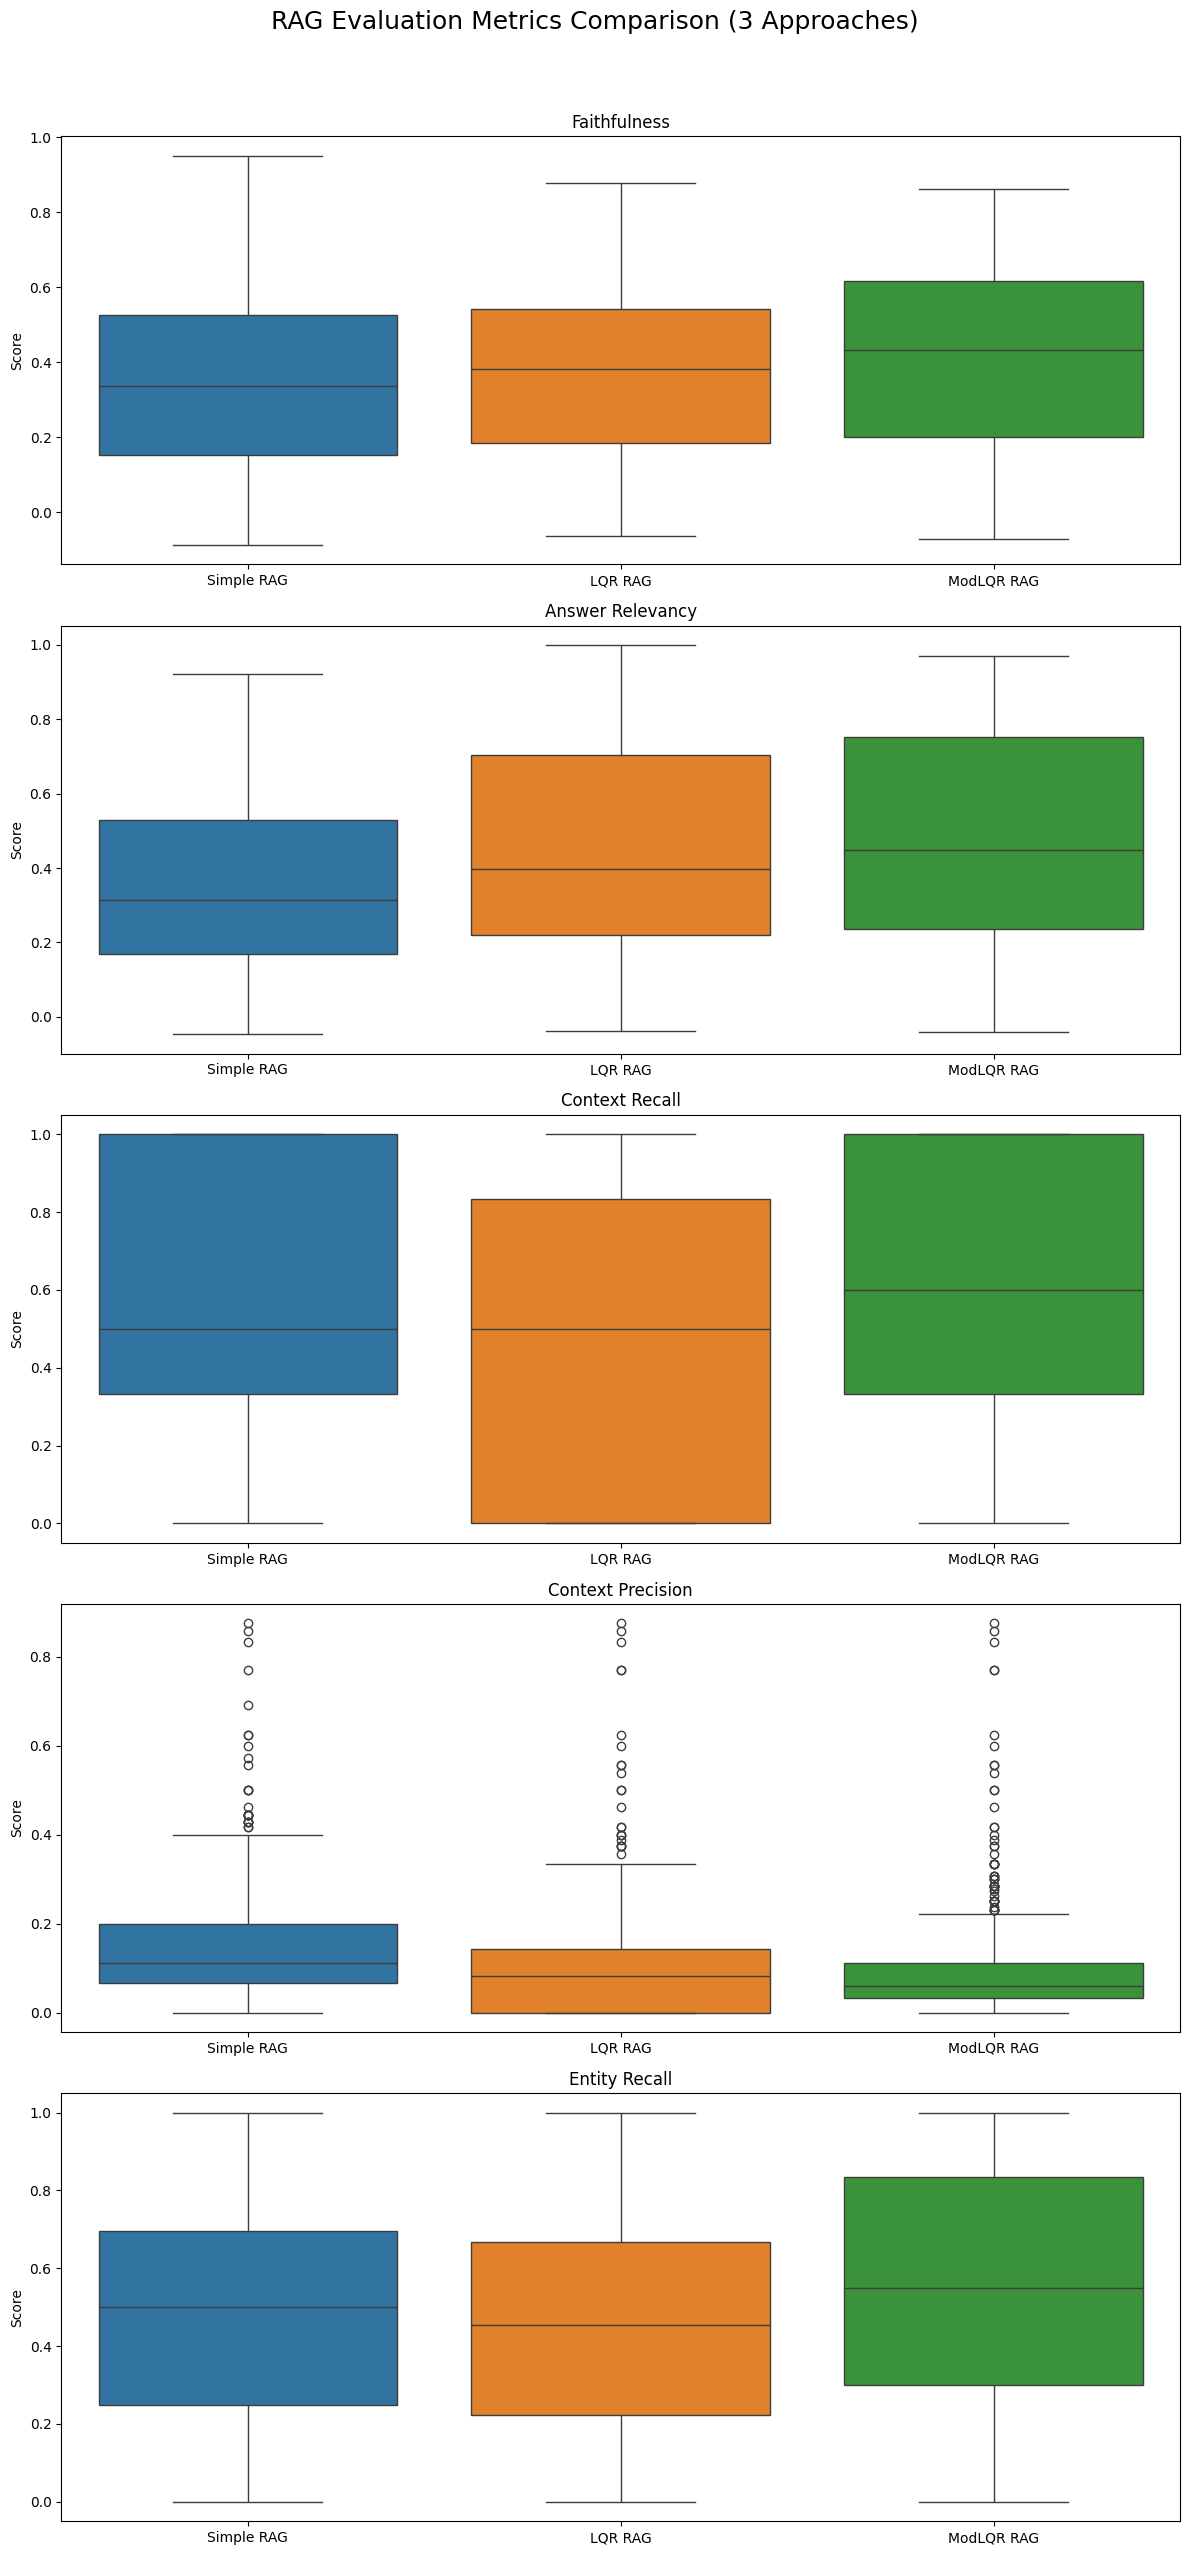

In [17]:
results_df = evaluate_multiple_rag_approaches(full_df)
plot_all_metrics(results_df)

In [18]:
import pandas as pd

def summarize_results(results_df):
    # Define metrics list
    metrics = ['faithfulness', 'answer_relevancy', 'context_recall', 'context_precision', 'entity_recall']

    summary_data = []

    for metric in metrics:
        summary_data.append({
            'Metric': metric.replace('_', ' ').title(),
            'Simple RAG': results_df[f'simple_rag_{metric}'].mean(),
            'LQR RAG': results_df[f'lqr_rag_{metric}'].mean(),
            'ModLQR RAG': results_df[f'modlqr_rag_{metric}'].mean()
        })

    summary_df = pd.DataFrame(summary_data)
    # Formatting for readability
    summary_df[['Simple RAG', 'LQR RAG', 'ModLQR RAG']] = summary_df[['Simple RAG', 'LQR RAG', 'ModLQR RAG']].round(3)

    print("\nAverage Metrics Summary:")
    display(summary_df)

    return summary_df

# Assuming your results_df columns are like 'simple_rag_faithfulness', 'lqr_rag_faithfulness', etc.
summary_df = summarize_results(results_df)



Average Metrics Summary:


,Metric,Simple RAG,LQR RAG,ModLQR RAG
0,Faithfulness,0.347,0.370,0.407
1,Answer Relevancy,0.360,0.454,0.481
2,Context Recall,0.566,0.502,0.605
3,Context Precision,0.144,0.106,0.093
4,Entity Recall,0.483,0.455,0.556


In [22]:
summary_df = summarize_results(results_df.iloc[99:])


Average Metrics Summary:


,Metric,Simple RAG,LQR RAG,ModLQR RAG
0,Faithfulness,0.344,0.365,0.413
1,Answer Relevancy,0.362,0.464,0.502
2,Context Recall,0.545,0.473,0.598
3,Context Precision,0.123,0.080,0.064
4,Entity Recall,0.475,0.445,0.567


In [21]:
results_df.to_csv("../../results/scores_results/RAGAs_results/llama3.1_res/RAGAs_complete_res.csv", index=False,encoding="utf-8-sig")

In [23]:
summary_df.to_csv("../../results/scores_results/RAGAs_results/llama3.1_res/RAGAs_summarize_res_after98.csv", index=False,encoding="utf-8-sig")